In [1]:
# import dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
# Import Dependencies for Database
from config import password
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import psycopg2

In [3]:
db_string = f"postgresql+psycopg2://postgres:" + password + "@127.0.0.1:5432/the_cheesery"

In [4]:
engine = create_engine(db_string)

In [5]:
inspector = inspect(engine)

In [6]:
inspector.get_table_names()

['cheese', 'the_cheesery']

In [7]:
session = Session(engine)

In [8]:
engine.execute("SELECT * from the_cheesery")

In [9]:
col_names_list = []

#i = 0
for i in range(len(inspector.get_columns('cheese'))):
    col_names_list.append(inspector.get_columns('cheese')[i]['name'])
    
print(col_names_list)

['cheese', 'company', 'city', 'price', 'milk', 'country', 'origin', 'classification', 'texture', 'color', 'flavor', 'vegetarian']


In [10]:
# create a df from database 
cheese_df = pd.DataFrame(columns = col_names_list)

In [11]:
# add in data
import sys
db = engine.execute("SELECT * from cheese")
for record in db:
    record_series = pd.Series(list(record), index = cheese_df.columns)
    
    cheese_df = cheese_df.append(record_series, ignore_index=True)

In [12]:
# review df
cheese_df

,cheese,company,city,price,milk,country,origin,classification,texture,color,flavor,vegetarian
0,crescenza,mozzarella company,dallas,9.39,cow,italy,italian,fresh soft,creamy,white,sweet,yes
1,smoked scamorza,mozzarella company,dallas,15.59,cow,italy,pasta filata,semi soft,firm,white,smokey,no
2,smoked mozzarella,mozzarella company,dallas,10.79,cow,italy,mozzarella,semi soft,bouncy,white,smokey,yes
3,queso oaxaca,mozzarella company,dallas,11.99,cow,mexico,pasta filata,semi hard,bouncy,white,buttery,yes
4,queso fresco,mozzarella company,dallas,10.79,cow,mexico,cottage,fresh soft,crumbly,white,milky,yes
...,...,...,...,...,...,...,...,...,...,...,...,...
98,feta,brazos valley cheese,waco,15,cow,greece,feta,soft brined,crumbly,white,tangy,no
99,marinated feta,brazos valley cheese,waco,14,cow,greece,feta,soft brined,crumbly,white,herby,no
100,marinated labneh,brazos valley cheese,waco,14,cow,middle east,labneh,soft,creamy,white,herby,no
101,mountain maple brie,brazos valley cheese,waco,22.5,cow,united states,brie,soft,creamy,cream,sweet,no


In [13]:
cheese_df.nunique()

cheese            98
company            6
city               8
price             41
milk               8
country           10
origin            24
classification     9
texture            5
color              8
flavor            12
vegetarian         2
dtype: int64

ML Data PreProcessing

In [14]:
# bin extra values
cheese_df.city.value_counts()

austin        22
dublin        21
waco          18
dallas        15
dallas        12
white oak     10
manor          3
dallas,        1
Name: city, dtype: int64

In [15]:
city_counts = cheese_df.city.value_counts()

In [16]:
# city_counts.plot.density()
# replace city values with "other cities"
replace_cities = list(city_counts[city_counts < 16].index)

# Replace in DataFrame
for city in replace_cities:
    cheese_df.city = cheese_df.city.replace(city,"dallas area")


# Check to make sure binning was successful
cheese_df.city.value_counts()

dallas area    41
austin         22
dublin         21
waco           18
Name: city, dtype: int64

In [19]:
cheese_df.country.value_counts()

united states    44
england          15
italy            14
france           11
mexico            6
greece            5
netherlands       5
italy/france      1
switzerland       1
middle east       1
Name: country, dtype: int64

In [20]:
# Visualize the value counts
country_counts = cheese_df.country.value_counts()

# country_counts.plot.density()

In [21]:
# replace country values with "other country"
replace_countries = list(country_counts[country_counts < 3].index)

# Replace in DataFrame
for country in replace_countries:
    cheese_df.country = cheese_df.country.replace(country,"other country")


# Check to make sure binning was successful
cheese_df.country.value_counts()

united states    44
england          15
italy            14
france           11
mexico            6
greece            5
netherlands       5
other country     3
Name: country, dtype: int64

In [25]:
# Group wine price into bins.
price_counts = cheese_df.price.value_counts()
price_counts

16.5     13
2.25      7
7.95      7
2.5       6
11        4
10.79     4
14        4
2.75      4
18        3
10        3
10.5      3
11.5      3
3         3
9.39      3
11.39     3
11.99     3
13.49     2
8.95      2
15.59     2
7.99      2
15.5      1
9.5       1
12.75     1
19        1
15        1
2         1
12        1
12.5      1
11.29     1
9.69      1
22.59     1
28.19     1
10.49     1
18.19     1
10.69     1
5.69      1
7.59      1
9.49      1
7.29      1
12.69     1
22.5      1
Name: price, dtype: int64

In [28]:
# change price type
cheese_df['price'] = cheese_df['price'].astype(float, errors='raise')

In [29]:
# Create price bins
price_bins = [0, 5, 10, 15, 20, 30,]
cheese_df.groupby(pd.cut(cheese_df["price"], price_bins)).count()

price_bin_names = ["less than $5","$5-10","$10-15","$15-20", "$20-30"]

# Make a new column in dataframe for price bins.
cheese_df["price_bins"] = pd.cut(cheese_df["price"], price_bins, labels=price_bin_names)

# Check dataframe
cheese_df.tail()

,cheese,company,city,price,milk,country,origin,classification,texture,color,flavor,vegetarian,price_bins
98,feta,brazos valley cheese,waco,15.0,cow,greece,feta,soft brined,crumbly,white,tangy,no,$10-15
99,marinated feta,brazos valley cheese,waco,14.0,cow,greece,feta,soft brined,crumbly,white,herby,no,$10-15
100,marinated labneh,brazos valley cheese,waco,14.0,cow,other country,labneh,soft,creamy,white,herby,no,$10-15
101,mountain maple brie,brazos valley cheese,waco,22.5,cow,united states,brie,soft,creamy,cream,sweet,no,$20-30
102,orchard blue,brazos valley cheese,waco,16.5,cow,united states,blue,semi soft,creamy,pale yellow,tangy,no,$15-20


In [31]:
# can create a df to train/test
cheese_data_ml = cheese_df.drop(columns=["price"])
cheese_data_ml

,cheese,company,city,milk,country,origin,classification,texture,color,flavor,vegetarian,price_bins
0,crescenza,mozzarella company,dallas area,cow,italy,italian,fresh soft,creamy,white,sweet,yes,$5-10
1,smoked scamorza,mozzarella company,dallas area,cow,italy,pasta filata,semi soft,firm,white,smokey,no,$15-20
2,smoked mozzarella,mozzarella company,dallas area,cow,italy,mozzarella,semi soft,bouncy,white,smokey,yes,$10-15
3,queso oaxaca,mozzarella company,dallas area,cow,mexico,pasta filata,semi hard,bouncy,white,buttery,yes,$10-15
4,queso fresco,mozzarella company,dallas area,cow,mexico,cottage,fresh soft,crumbly,white,milky,yes,$10-15
...,...,...,...,...,...,...,...,...,...,...,...,...
98,feta,brazos valley cheese,waco,cow,greece,feta,soft brined,crumbly,white,tangy,no,$10-15
99,marinated feta,brazos valley cheese,waco,cow,greece,feta,soft brined,crumbly,white,herby,no,$10-15
100,marinated labneh,brazos valley cheese,waco,cow,other country,labneh,soft,creamy,white,herby,no,$10-15
101,mountain maple brie,brazos valley cheese,waco,cow,united states,brie,soft,creamy,cream,sweet,no,$20-30


In [33]:
# drop any lingering nulls 
cheese_data_ml = cheese_data_ml.dropna()
cheese_data_ml

,cheese,company,city,milk,country,origin,classification,texture,color,flavor,vegetarian,price_bins
0,crescenza,mozzarella company,dallas area,cow,italy,italian,fresh soft,creamy,white,sweet,yes,$5-10
1,smoked scamorza,mozzarella company,dallas area,cow,italy,pasta filata,semi soft,firm,white,smokey,no,$15-20
2,smoked mozzarella,mozzarella company,dallas area,cow,italy,mozzarella,semi soft,bouncy,white,smokey,yes,$10-15
3,queso oaxaca,mozzarella company,dallas area,cow,mexico,pasta filata,semi hard,bouncy,white,buttery,yes,$10-15
4,queso fresco,mozzarella company,dallas area,cow,mexico,cottage,fresh soft,crumbly,white,milky,yes,$10-15
...,...,...,...,...,...,...,...,...,...,...,...,...
98,feta,brazos valley cheese,waco,cow,greece,feta,soft brined,crumbly,white,tangy,no,$10-15
99,marinated feta,brazos valley cheese,waco,cow,greece,feta,soft brined,crumbly,white,herby,no,$10-15
100,marinated labneh,brazos valley cheese,waco,cow,other country,labneh,soft,creamy,white,herby,no,$10-15
101,mountain maple brie,brazos valley cheese,waco,cow,united states,brie,soft,creamy,cream,sweet,no,$20-30


CHECKPOINT: BEGIN ML TRAIN/TEST

In [37]:
# create df for cheese names to merge after encoding 
origin_labels = cheese_data_ml.drop(columns=["cheese", "company", "city", "milk", "country", "classification", "texture", "color", "flavor", "vegetarian", "price_bins"])

In [38]:
# double check df
origin_labels

,origin
0,italian
1,pasta filata
2,mozzarella
3,pasta filata
4,cottage
...,...
98,feta
99,feta
100,labneh
101,brie


In [39]:
# check df before encoding
cheese_ft = cheese_data_ml.drop(columns=["origin"])
cheese_ft

,cheese,company,city,milk,country,classification,texture,color,flavor,vegetarian,price_bins
0,crescenza,mozzarella company,dallas area,cow,italy,fresh soft,creamy,white,sweet,yes,$5-10
1,smoked scamorza,mozzarella company,dallas area,cow,italy,semi soft,firm,white,smokey,no,$15-20
2,smoked mozzarella,mozzarella company,dallas area,cow,italy,semi soft,bouncy,white,smokey,yes,$10-15
3,queso oaxaca,mozzarella company,dallas area,cow,mexico,semi hard,bouncy,white,buttery,yes,$10-15
4,queso fresco,mozzarella company,dallas area,cow,mexico,fresh soft,crumbly,white,milky,yes,$10-15
...,...,...,...,...,...,...,...,...,...,...,...
98,feta,brazos valley cheese,waco,cow,greece,soft brined,crumbly,white,tangy,no,$10-15
99,marinated feta,brazos valley cheese,waco,cow,greece,soft brined,crumbly,white,herby,no,$10-15
100,marinated labneh,brazos valley cheese,waco,cow,other country,soft,creamy,white,herby,no,$10-15
101,mountain maple brie,brazos valley cheese,waco,cow,united states,soft,creamy,cream,sweet,no,$20-30


In [40]:
# encode categorical variables 
cheese_cat = pd.get_dummies(cheese_ft)

In [41]:
cheese_cat

,cheese_ash chevre,cheese_baby caciotta,cheese_basil pesto chevre,cheese_biervesa,cheese_black garlic havarti,cheese_blueberry chipotle chevre,cheese_blueberry vanilla chevre,cheese_bocconcini,cheese_bosque blue,cheese_brie,...,flavor_tangy,flavor_tart,flavor_umami,vegetarian_no,vegetarian_yes,price_bins_less than $5,price_bins_$5-10,price_bins_$10-15,price_bins_$15-20,price_bins_$20-30
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
99,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [43]:
# merge the cheese name and cat dfs together
cheese_ml = origin_labels.merge(cheese_cat,left_index=True,right_index=True)

In [44]:
cheese_ml

,origin,cheese_ash chevre,cheese_baby caciotta,cheese_basil pesto chevre,cheese_biervesa,cheese_black garlic havarti,cheese_blueberry chipotle chevre,cheese_blueberry vanilla chevre,cheese_bocconcini,cheese_bosque blue,...,flavor_tangy,flavor_tart,flavor_umami,vegetarian_no,vegetarian_yes,price_bins_less than $5,price_bins_$5-10,price_bins_$10-15,price_bins_$15-20,price_bins_$20-30
0,italian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,pasta filata,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,mozzarella,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,pasta filata,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,cottage,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,feta,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
99,feta,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
100,labneh,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
101,brie,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [49]:
# split data for testing 
# target - cheese families
y = cheese_ml["origin"].values
# Features - price, flavor
X = cheese_ml.drop(["origin"],axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.2)

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [51]:
#Setup arrays to store training and test accuracies
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 

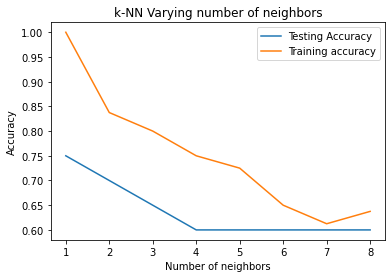

In [52]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [53]:
# Fitting K-NN to the Training set
knn = KNeighborsClassifier(n_neighbors = 1)

In [54]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [55]:
knn.score(X_test, y_test)

0.75

In [56]:
y_pred = knn.predict(X_test)

In [57]:
# print confusion matrix 
confusion_matrix(y_test, y_pred)


array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4]], dtype=int64)

In [58]:
acc_score = accuracy_score(y_test, y_pred)

In [60]:
# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, y_pred))

Accuracy Score : 0.75
Classification Report
               precision    recall  f1-score   support

         blue       0.00      0.00      0.00         1
         brie       1.00      1.00      1.00         1
      cheddar       1.00      0.71      0.83         7
       chevre       1.00      1.00      1.00         2
      cottage       0.00      0.00      0.00         0
 cream cheese       1.00      1.00      1.00         1
     montasio       1.00      1.00      1.00         1
monterey jack       0.00      0.00      0.00         0
   mozzarella       0.50      1.00      0.67         1
 pasta filata       0.00      0.00      0.00         1
     raw milk       0.00      0.00      0.00         1
        vegan       1.00      1.00      1.00         4

     accuracy                           0.75        20
    macro avg       0.54      0.56      0.54        20
 weighted avg       0.82      0.75      0.77        20



In [61]:
#import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [62]:
#In case of classifier like knn the parameter to be tuned is n_neighbors
param_grid = {'n_neighbors':np.arange(1,50)}

In [63]:
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=3)
knn_cv.fit(X,y)

C:\Users\kalynbolton\anaconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [64]:
knn_cv.best_score_

0.7198455139631611

In [65]:
knn_cv.best_params_

{'n_neighbors': 1}

In [66]:
# try another classification model
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier(random_state=1)

In [67]:
# clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [68]:
# clf.score(X_test, y_test) = 0.6

0.6

In [70]:
# y_pred = clf.predict(X_test)

# print confusion matrix 
# confusion_matrix(y_test, y_pred)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3]], dtype=int64)

In [71]:
# acc_score = accuracy_score(y_test, y_pred)